In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3.distributions.transforms as tr
import theano.tensor as tt
from scipy.special import gammaln



plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.5


In [2]:
# rat data (BDA3, p. 102)
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [3]:
#Compute on log scale because products turn to sums
def log_likelihood(alpha,beta,y,n):
    LL = 0

    #Summing over data
    for Y,N in zip(y,n):
        LL+= gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta) + gammaln(alpha+Y) +gammaln(beta+N-Y) - gammaln(alpha+beta+N)

    return LL

def log_prior(A,B):

    return -5/2*np.log(A+B)

def trans_to_beta(x,y):

    return np.exp(y)/(np.exp(x)+1)

def trans_to_alpha(x,y):

    return np.exp(x)*trans_to_beta(x,y)

#Create space for the parameterization in which we wish to plot
X,Z = np.meshgrid(np.arange(-2.3,-1.3,0.01),np.arange(1,5,0.01))
param_space = np.c_[X.ravel(), Z.ravel()]
df= pd.DataFrame(param_space, columns=['X','Z'])

#Transform the space back to alpha beta to compute the log-posterior
df['alpha']= trans_to_alpha(df.X,df.Z)
df['beta'] = trans_to_beta(df.X,df.Z)

df['log_posterior'] = log_prior(df.alpha,df.beta) + log_likelihood(df.alpha,df.beta, y,n)
df['log_jacobian'] = np.log(df.alpha) + np.log(df.beta)

df['transformed'] = df.log_posterior+df.log_jacobian
df['exp_trans'] = np.exp(df.transformed - df.transformed.max())

#This will ensure the density is normalized
df['normed_exp_trans'] = df.exp_trans/df.exp_trans.sum()


surface = df.set_index(['X','Z']).exp_trans.unstack().values.T

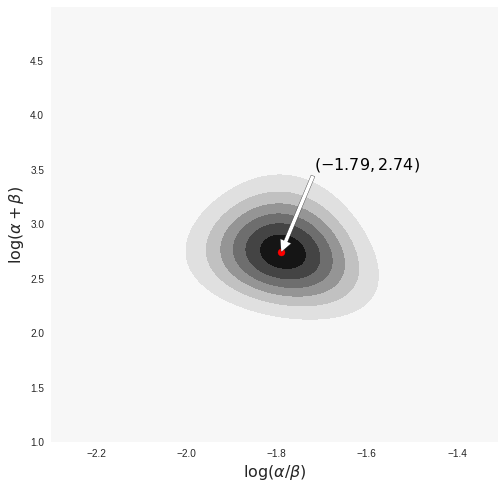

In [4]:
fig, ax = plt.subplots(figsize = (8,8))
ax.contourf(X,Z, surface)
ax.set_xlabel(r'$\log(\alpha/\beta)$', fontsize = 16)
ax.set_ylabel(r'$\log(\alpha+\beta)$', fontsize = 16)

ix_z,ix_x = np.unravel_index(np.argmax(surface, axis=None), surface.shape)
ax.scatter([X[0,ix_x]], [Z[ix_z,0]], color = 'red')

text= r"$({a},{b})$".format(a = np.round(X[0,ix_x],2), b = np.round(Z[ix_z,0],2))

ax.annotate(text,
            xy = (X[0,ix_x],Z[ix_z,0]),
            xytext=(-1.6, 3.5),
            ha = 'center',
            fontsize = 16,
            color = 'black',
            arrowprops=dict(
                            facecolor='white',

                            )
           );

In [7]:
#Estimated mean of alpha
(df.alpha*df.normed_exp_trans).sum()

2.402561508176057

In [9]:
#Estimated mean of beta
(df.beta*df.normed_exp_trans).sum()

14.31948668205746

In [10]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))



with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                       shape=2,
                       testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))

    X = pm.Deterministic('X',tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z',tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:16<00:00, 714.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


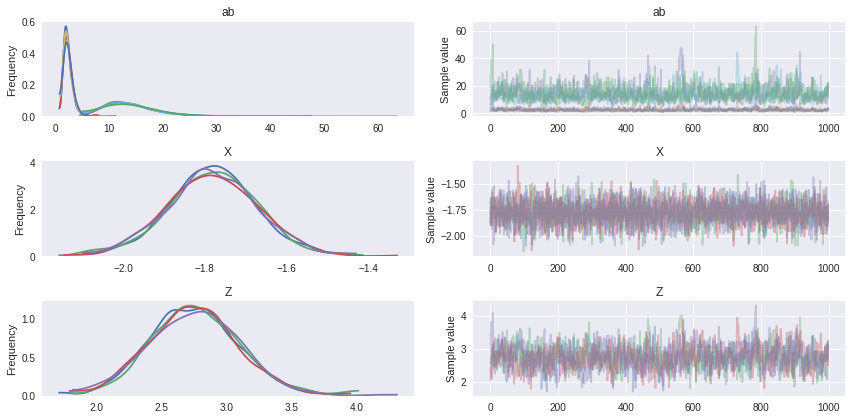

In [11]:

#Check the trace. Looks good!
pm.traceplot(trace, varnames=['ab','X','Z']);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0046cf0898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0046fef4a8>], dtype=object)

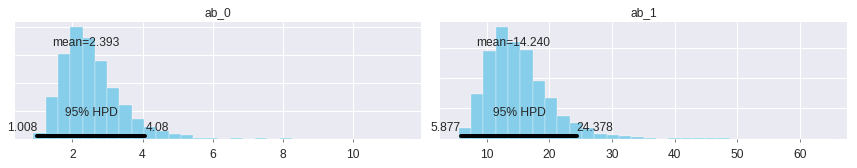

In [12]:
pm.posteriorplot.plot_posterior(trace, varnames = ['ab'])

In [28]:
df=pd.read_csv('frax.csv')
df.head()

,Unnamed: 0,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk,balance_q,credl_q,Segmento
0,1,1,35,1,3000,4,14,2,0,2,1,3
1,2,0,2,1,0,9,0,18,0,1,4,3
2,3,0,2,1,0,27,9,16,0,1,4,3
3,4,1,15,1,0,12,0,5,0,1,2,3
4,5,1,46,1,0,11,16,7,0,1,3,3


In [29]:
len(df)

100000

In [30]:
nclase=len(df['Segmento'].unique())
clase_idx=df.Segmento.values
clase_idx

array([3, 3, 3, ..., 1, 2, 3])

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [ppx]
Sampling 4 chains: 100%|██████████| 44000/44000 [01:35<00:00, 461.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


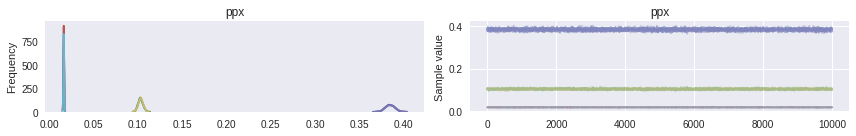

In [31]:
model = pm.Model()

with model:
    ppx = pm.Beta( 'ppx', alpha=1, beta=1 ,shape=nclase)
    y_obsx = pm.Bernoulli( 'y_obsx', p=ppx[clase_idx-1], observed=df['fraudRisk'] )
    step = pm.Metropolis()
    trace = pm.sample( 10000,tune=1000, step=step, progressbar=True )

pm.traceplot( trace )
plt.show()

In [32]:
ppx

ppx

In [7]:
df[df['gender']==2]['fraudRisk'].mean()

0.07266534941763728

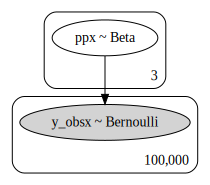

In [33]:
pm.model_to_graphviz(model)

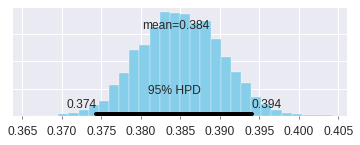

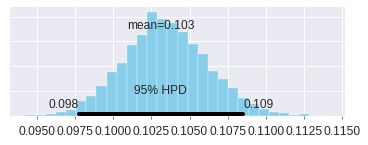

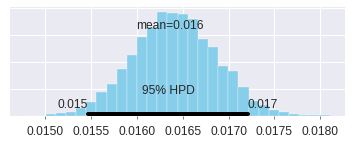

In [34]:
pm.plot_posterior(trace['ppx'][:,0])
pm.plot_posterior(trace['ppx'][:,1])
pm.plot_posterior(trace['ppx'][:,2])
plt.show()

In [21]:
trace['ppx']

array([[ 0.05320164,  0.07210547],
       [ 0.05320164,  0.07210547],
       [ 0.05320164,  0.07210547],
       ..., 
       [ 0.05271107,  0.07410041],
       [ 0.05271107,  0.07410041],
       [ 0.05448694,  0.07358766]])